# Group Members:

- LookKaew Pongtiyapaiboon
- Muhammad Murtadha Ramadhan
- Cathy Tong
- Catherine Huang
- Kaicheng (Cathy) Zhang

In [1]:
!pip install cvxpy
!pip install pyarrow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
import cvxpy as cp
import os
os.getcwd()
pd.set_option('display.max_columns', None)

# Import Necessary Datasets

In this final project, we've planned to build an investment strategy that first selects assets based on factor exposures which are value and quality in the very first step. The datasets we're going to use are CRSP and Compustat.

In [2]:
stocks = pd.read_feather('crsp_monthly_stocks.feather')
cstat  = pd.read_feather('compustat_annual.feather')

In [3]:
stocks['DATE'] = stocks['DATE'] + MonthEnd(0)
stocks['date'] = stocks['DATE']
stocks['PRC']  = np.abs(stocks['PRC'])
stocks['MV'] = stocks['SHROUT']*stocks['PRC']
stocks.drop(['SHROUT','SHRCD','EXCHCD','SICCD','PRC','VOL'], axis=1, inplace=True)
stocks.set_index(['PERMNO','DATE'], inplace=True)
stocks.sort_index(inplace=True)
stocks.head()

RET   SPREAD      RETX       date            MV
PERMNO  DATE                                                            
10000.0 1986-01-31       NaN  0.25000       NaN 1986-01-31  16100.000000
        1986-02-28 -0.257143  0.25000 -0.257143 1986-02-28  11960.000000
        1986-03-31  0.365385  0.12500  0.365385 1986-03-31  16330.000000
        1986-04-30 -0.098592  0.25000 -0.098592 1986-04-30  15172.000000
        1986-05-31 -0.222656  0.09375 -0.222656 1986-05-31  11793.859375

In [4]:
cstat.rename(columns={"LPERMNO":"PERMNO", "DATADATE":"DATE"}, inplace=True)
cstat.set_index(['PERMNO','DATE'], inplace=True)
cstat.sort_index(inplace=True)
cstat.head()

FYEAR      AT    CEQ    CHE      LT  PSTK    SEQ    DVT  \
PERMNO  DATE                                                                   
10000.0 1986-10-31  1986.0   2.115  0.418  0.348   1.697   0.0  0.418  0.000   
10001.0 1986-06-30  1986.0  12.242  5.432  0.746   6.810   0.0  5.432  0.365   
        1987-06-30  1987.0  11.771  5.369  0.729   6.402   0.0  5.369  0.416   
        1988-06-30  1988.0  11.735  5.512  0.744   6.223   0.0  5.512  0.427   
        1989-06-30  1989.0  18.565  6.321  1.177  12.244   0.0  6.321  0.459   

                       IB    SALE   CAPX  
PERMNO  DATE                              
10000.0 1986-10-31 -0.730   1.026  0.240  
10001.0 1986-06-30  0.669  21.460  0.551  
        1987-06-30  0.312  16.621  0.513  
        1988-06-30  0.542  16.978  0.240  
        1989-06-30  1.208  22.910  0.444

In [5]:
stocks = pd.read_feather('crsp_monthly_stocks.feather')
cstat  = pd.read_feather('compustat_annual.feather')

In [6]:
stocks.head(5)
stocks.describe()

,PERMNO,DATE,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SPREAD,RETX,SHROUT
count,3.452888e+06,3452888,3.452888e+06,3.452888e+06,3.450444e+06,3.353586e+06,3.084901e+06,3.327329e+06,652462.000000,3.327329e+06,3.449185e+06
mean,5.339424e+04,1994-05-28 01:08:05.328687232,1.078982e+01,2.231129e+00,4.710997e+03,3.390743e+01,9.458951e+04,1.131887e-02,0.606743,1.006487e-02,4.941455e+04
min,1.000000e+04,1962-01-31 00:00:00,1.000000e+01,-2.000000e+00,0.000000e+00,-1.832500e+03,0.000000e+00,-9.956895e-01,0.000700,-9.956895e-01,0.000000e+00
25%,2.655000e+04,1982-09-30 00:00:00,1.100000e+01,1.000000e+00,3.310000e+03,1.750000e+00,8.660000e+02,-6.753246e-02,0.250000,-6.896552e-02,3.019000e+03
50%,5.519200e+04,1994-08-31 00:00:00,1.100000e+01,3.000000e+00,4.231000e+03,1.025000e+01,5.102000e+03,0.000000e+00,0.500000,0.000000e+00,9.059000e+03
75%,7.985100e+04,2005-10-31 00:00:00,1.100000e+01,3.000000e+00,6.311000e+03,2.456250e+01,3.531200e+04,7.142857e-02,0.750000,7.017544e-02,2.955700e+04
max,9.343600e+04,2023-06-30 00:00:00,1.100000e+01,3.300000e+01,9.999000e+03,5.289210e+05,2.012427e+08,2.400000e+01,885.000000,2.400000e+01,2.920640e+07
std,2.760474e+04,NaN,4.074335e-01,1.018957e+00,2.226137e+03,2.032218e+03,6.735851e+05,1.838868e-01,1.655317,1.839046e-01,2.646959e+05


We're going to clean up the data by performing the following steps:

1. Adjust Date: Set the date to the last day of each month instead of the last trading day to simplify merging with other datasets.

2. Fix Price Sign: Convert the closing price to its absolute value to remove CRSP's warning for non-trading shares (which uses a negative price).

3. Calculate Market Value: Define market value as the product of shares outstanding and the closing price.

4. Drop Unneeded Columns: Remove shares outstanding, share code, EXCHCD, SICCD, PRC, and VOL to make the dataframe cleaner. The share code was only used for initial data filtering.

5. Set Index: Set the index to PERMNO and DATE.

6. Sort Data: Sort the dataframe by the index.

7. Review: Display the cleaned dataframe.

In [7]:
stocks['DATE'] = stocks['DATE'] + MonthEnd(0)
stocks['date'] = stocks['DATE']
stocks['PRC']  = np.abs(stocks['PRC'])
stocks['MV'] = stocks['SHROUT']*stocks['PRC']
stocks.drop(['SHROUT','SHRCD','EXCHCD','SICCD','PRC','VOL'], axis=1, inplace=True)
stocks.set_index(['PERMNO','DATE'], inplace=True)
stocks.sort_index(inplace=True)
stocks.head()

RET   SPREAD      RETX       date            MV
PERMNO  DATE                                                            
10000.0 1986-01-31       NaN  0.25000       NaN 1986-01-31  16100.000000
        1986-02-28 -0.257143  0.25000 -0.257143 1986-02-28  11960.000000
        1986-03-31  0.365385  0.12500  0.365385 1986-03-31  16330.000000
        1986-04-30 -0.098592  0.25000 -0.098592 1986-04-30  15172.000000
        1986-05-31 -0.222656  0.09375 -0.222656 1986-05-31  11793.859375

In [9]:
cstat.head(5)

,DATADATE,FYEAR,LPERMNO,AT,CEQ,CHE,LT,PSTK,SEQ,DVT,IB,SALE,CAPX
0,1970-12-31,1970.0,25881.0,33.450,10.544,1.660,22.906,0.000,10.544,0.000,1.878,45.335,2.767
1,1971-12-31,1971.0,25881.0,29.330,8.381,2.557,20.948,0.000,8.382,0.000,0.138,47.033,1.771
2,1972-12-31,1972.0,25881.0,19.907,7.021,2.027,12.886,0.000,7.021,0.000,1.554,34.362,1.254
3,1973-12-31,1973.0,25881.0,21.771,8.567,1.357,13.204,0.000,8.567,0.000,1.863,37.750,1.633
4,1974-12-31,1974.0,25881.0,25.638,9.843,1.338,15.381,0.414,10.257,0.021,1.555,50.325,1.313


Rename two columns from `LPERMNO` to `PERMNO` and from `DATADATE` to `DATE`

In [9]:
cstat.rename(columns={"LPERMNO":"PERMNO", "DATADATE":"DATE"}, inplace=True)
cstat.head(5)

,DATE,FYEAR,PERMNO,AT,CEQ,CHE,LT,PSTK,SEQ,DVT,IB,SALE,CAPX
0,1970-12-31,1970.0,25881.0,33.450,10.544,1.660,22.906,0.000,10.544,0.000,1.878,45.335,2.767
1,1971-12-31,1971.0,25881.0,29.330,8.381,2.557,20.948,0.000,8.382,0.000,0.138,47.033,1.771
2,1972-12-31,1972.0,25881.0,19.907,7.021,2.027,12.886,0.000,7.021,0.000,1.554,34.362,1.254
3,1973-12-31,1973.0,25881.0,21.771,8.567,1.357,13.204,0.000,8.567,0.000,1.863,37.750,1.633
4,1974-12-31,1974.0,25881.0,25.638,9.843,1.338,15.381,0.414,10.257,0.021,1.555,50.325,1.313


In [10]:
cstat.set_index(['PERMNO','DATE'], inplace=True)
cstat.sort_index(inplace=True)
cstat.head()

FYEAR      AT    CEQ    CHE      LT  PSTK    SEQ    DVT  \
PERMNO  DATE                                                                   
10000.0 1986-10-31  1986.0   2.115  0.418  0.348   1.697   0.0  0.418  0.000   
10001.0 1986-06-30  1986.0  12.242  5.432  0.746   6.810   0.0  5.432  0.365   
        1987-06-30  1987.0  11.771  5.369  0.729   6.402   0.0  5.369  0.416   
        1988-06-30  1988.0  11.735  5.512  0.744   6.223   0.0  5.512  0.427   
        1989-06-30  1989.0  18.565  6.321  1.177  12.244   0.0  6.321  0.459   

                       IB    SALE   CAPX  
PERMNO  DATE                              
10000.0 1986-10-31 -0.730   1.026  0.240  
10001.0 1986-06-30  0.669  21.460  0.551  
        1987-06-30  0.312  16.621  0.513  
        1988-06-30  0.542  16.978  0.240  
        1989-06-30  1.208  22.910  0.444

## Import the Fama-French Monthly Dataset

In [11]:
fama_french_data = pd.read_csv('FamaFrenchMonthly.csv')
fama_french_data[['Mkt-RF', 'SMB', 'HML', 'RF']] = fama_french_data[['Mkt-RF', 'SMB', 'HML', 'RF']]/100
fama_french_data['Date'] = pd.to_datetime(fama_french_data['Date'].astype(str).str[:6] + '01') + pd.offsets.MonthEnd(0)
fama_french_data.set_index('Date', inplace = True)
fama_french_data.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031


# Data Preparation

We now need to merge these data.  Unfortunately, the data occasionally have multiple rows with the same PERMNO and DATE.  So, we have to eliminate duplicate PERMNO/DATE pairs.

We will assume that if there is more than one PERMNO on the same date, then the bigger one is probably more important and therefore more likely to be correct.

Thus, we're going to sort the dataframe in ascending order by PERMNO and DATE.  

In [12]:
stocks = stocks.sort_values(by = ['PERMNO','DATE'], ascending = [True, True])
cstat  = cstat.sort_values(by = ['PERMNO','DATE'], ascending = [True, True])

In [13]:
stocks = stocks.merge(cstat[['IB','SALE']], how='left', on=['PERMNO','DATE'])

In [14]:
stocks.head()

RET   SPREAD      RETX       date            MV  IB  \
PERMNO  DATE                                                                   
10000.0 1986-01-31       NaN  0.25000       NaN 1986-01-31  16100.000000 NaN   
        1986-02-28 -0.257143  0.25000 -0.257143 1986-02-28  11960.000000 NaN   
        1986-03-31  0.365385  0.12500  0.365385 1986-03-31  16330.000000 NaN   
        1986-04-30 -0.098592  0.25000 -0.098592 1986-04-30  15172.000000 NaN   
        1986-05-31 -0.222656  0.09375 -0.222656 1986-05-31  11793.859375 NaN   

                    SALE  
PERMNO  DATE              
10000.0 1986-01-31   NaN  
        1986-02-28   NaN  
        1986-03-31   NaN  
        1986-04-30   NaN  
        1986-05-31   NaN

As mentioned previously, we are going to select assets based on factor exposures which are value and profitability. In this final project, we are going to use earning to price ratio (IB divided by MV:Market Value for these datasets) for value criteria and profitability (Net Income Margin, which is `IB` (income) divided by `SALE` for quality criteria.

Next, we will calculate the E/P ratio in two ways.

First, we use the latest known value of earnings (column IB) divided by the corresponding market value (column MV) at the most recent fiscal year-end. We then lag this ratio by 6 months to account for the delay in earnings reporting after the quarter ends.

To make the E/P ratio meaningful, we need to multiply it by 1000. This is because CRSP and Compustat use different units: CRSP's shares outstanding (used to calculate MV) are in thousands, while Compustat's earnings (IB) are in millions. Multiplying by 1000 makes these values comparable.

In [16]:
stocks['lag EP v1'] = stocks['IB'].groupby('PERMNO').shift(6) / stocks['MV'].groupby('PERMNO').shift(6) * 1000

In [17]:
stocks.loc[14593].tail(12)

,RET,SPREAD,RETX,date,MV,IB,SALE,lag EP v1
DATE,,,,,,,,
2022-07-31,0.188634,NaN,0.188634,2022-07-31,2.611658e+09,NaN,NaN,NaN
2022-08-31,-0.031137,NaN,-0.032552,2022-08-31,2.526644e+09,NaN,NaN,NaN
2022-09-30,-0.120977,NaN,-0.120977,2022-09-30,2.203381e+09,99803.0,394328.0,NaN
2022-10-31,0.109551,NaN,0.109551,2022-10-31,2.439351e+09,NaN,NaN,NaN
2022-11-30,-0.033129,NaN,-0.034629,2022-11-30,2.354879e+09,NaN,NaN,NaN
2022-12-31,-0.122273,NaN,-0.122273,2022-12-31,2.058404e+09,NaN,NaN,NaN
2023-01-31,0.110521,NaN,0.110521,2023-01-31,2.282948e+09,NaN,NaN,NaN
2023-02-28,0.023217,NaN,0.021623,2023-02-28,2.332313e+09,NaN,NaN,NaN
2023-03-31,0.118649,NaN,0.118649,2023-03-31,2.592790e+09,NaN,NaN,0.045295


The calculations are correct, but they produce only one E/P ratio per year. To fill in the rest, we use the _fillna_ method with the _pad_ option, which fills missing values with the most recent available data. Since we're using older data, there is no look-ahead bias. The groupby('PERMNO') step ensures that earnings are only filled within the same firm. The limit=15 option prevents using data older than 15 months, which should only apply in rare cases.

In [18]:
stocks['lag EP v1']  = stocks['lag EP v1'].groupby('PERMNO').fillna(method='pad', limit=15)

In [19]:
stocks.loc[14593].tail(12)

,RET,SPREAD,RETX,date,MV,IB,SALE,lag EP v1
DATE,,,,,,,,
2022-07-31,0.188634,NaN,0.188634,2022-07-31,2.611658e+09,NaN,NaN,0.040733
2022-08-31,-0.031137,NaN,-0.032552,2022-08-31,2.526644e+09,NaN,NaN,0.040733
2022-09-30,-0.120977,NaN,-0.120977,2022-09-30,2.203381e+09,99803.0,394328.0,0.040733
2022-10-31,0.109551,NaN,0.109551,2022-10-31,2.439351e+09,NaN,NaN,0.040733
2022-11-30,-0.033129,NaN,-0.034629,2022-11-30,2.354879e+09,NaN,NaN,0.040733
2022-12-31,-0.122273,NaN,-0.122273,2022-12-31,2.058404e+09,NaN,NaN,0.040733
2023-01-31,0.110521,NaN,0.110521,2023-01-31,2.282948e+09,NaN,NaN,0.040733
2023-02-28,0.023217,NaN,0.021623,2023-02-28,2.332313e+09,NaN,NaN,0.040733
2023-03-31,0.118649,NaN,0.118649,2023-03-31,2.592790e+09,NaN,NaN,0.045295


We'll then use fillna in the same way to fill in missing values with older data for the `lag IB` column.

In [20]:
stocks['lag IB']  = stocks['IB'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15)

In [21]:
stocks.loc[14593].tail(12)

,RET,SPREAD,RETX,date,MV,IB,SALE,lag EP v1,lag IB
DATE,,,,,,,,,
2022-07-31,0.188634,NaN,0.188634,2022-07-31,2.611658e+09,NaN,NaN,0.040733,94680.0
2022-08-31,-0.031137,NaN,-0.032552,2022-08-31,2.526644e+09,NaN,NaN,0.040733,94680.0
2022-09-30,-0.120977,NaN,-0.120977,2022-09-30,2.203381e+09,99803.0,394328.0,0.040733,94680.0
2022-10-31,0.109551,NaN,0.109551,2022-10-31,2.439351e+09,NaN,NaN,0.040733,94680.0
2022-11-30,-0.033129,NaN,-0.034629,2022-11-30,2.354879e+09,NaN,NaN,0.040733,94680.0
2022-12-31,-0.122273,NaN,-0.122273,2022-12-31,2.058404e+09,NaN,NaN,0.040733,94680.0
2023-01-31,0.110521,NaN,0.110521,2023-01-31,2.282948e+09,NaN,NaN,0.040733,94680.0
2023-02-28,0.023217,NaN,0.021623,2023-02-28,2.332313e+09,NaN,NaN,0.040733,94680.0
2023-03-31,0.118649,NaN,0.118649,2023-03-31,2.592790e+09,NaN,NaN,0.045295,99803.0


Then, we're going to calculate `NIM`, which stands for net income margin. This profitability will be used for quality criteria.

The way we calculated is we take `IB`, which is equivalent to a firm's net income, divided by `SALE`. Again, we lagged it for 6 months to account for the delay in earnings and sales reporting after the quarter ends.

In [22]:
# calculate net income margin

stocks['lag NIM'] = stocks['IB'].groupby('PERMNO').shift(6) / stocks['SALE'].groupby('PERMNO').shift(6)

Again, we use the _fillna_ method with the _pad_ option, which fills missing values with the most recent available data. Since we're using older data, there is no look-ahead bias. The groupby('PERMNO') step ensures that earnings are only filled within the same firm. The limit=15 option prevents using data older than 15 months, which should only apply in rare cases.

In [23]:
stocks['lag IB'] = stocks['IB'] .groupby('PERMNO').shift(6).fillna(method='pad', limit=15)
stocks['lag SALE'] = stocks['SALE'] .groupby('PERMNO').shift(6).fillna(method='pad', limit=15)

In [24]:
stocks['lag NIM']  = stocks['lag NIM'].groupby('PERMNO').fillna(method='pad', limit=15)
stocks.tail()

RET  SPREAD      RETX       date            MV  IB  \
PERMNO  DATE                                                                  
93436.0 2023-02-28  0.187565     NaN  0.187565 2023-02-28  6.508876e+08 NaN   
        2023-03-31  0.008507     NaN  0.008507 2023-03-31  6.575059e+08 NaN   
        2023-04-30 -0.207992     NaN -0.207992 2023-04-30  5.207812e+08 NaN   
        2023-05-31  0.241130     NaN  0.241130 2023-05-31  6.463569e+08 NaN   
        2023-06-30  0.283627     NaN  0.283627 2023-06-30  8.296810e+08 NaN   

                    SALE  lag EP v1   lag IB   lag NIM  lag SALE  
PERMNO  DATE                                                      
93436.0 2023-02-28   NaN   0.005053   5519.0  0.102540   53823.0  
        2023-03-31   NaN   0.005053   5519.0  0.102540   53823.0  
        2023-04-30   NaN   0.005053   5519.0  0.102540   53823.0  
        2023-05-31   NaN   0.005053   5519.0  0.102540   53823.0  
        2023-06-30   NaN   0.032216  12556.0  0.154133   81462.0

In [25]:
stocks[['lag EP v1', 'lag NIM']].describe()

,lag EP v1,lag NIM
count,2.852727e+06,2.875462e+06
mean,-6.081832e-02,NaN
std,2.309022e+00,NaN
min,-9.170109e+02,-inf
25%,-1.267000e-02,-1.133952e-02
50%,4.943394e-02,3.678123e-02
75%,8.998487e-02,8.457245e-02
max,4.121234e+01,inf


In this step, we've noticed the following:

1. The two datasets don’t have the same end of month trading day (30th vs. 31st), leading to NaN in some rows of SEQ, SALE, etc.
2. Some companies have zero of `SALE`, causing Net Income Margin to be either positive or negative infinity.

Then, we've decided to filter the two criteria as follows:

1. `lag EP v1` will be in the range of 0.01 and 0.5
2. `lag NIM` will be lower than or equal to 0.5

In [26]:
stocks_filtered = stocks.loc[(stocks['lag EP v1']>0.01) & (stocks['lag EP v1']<.5) & (stocks['lag NIM']>0) & (stocks['lag NIM']<=0.5)]

In [27]:
stocks_filtered_copy = stocks_filtered.copy()
# stocks_filtered_copy = stocks_filtered_copy.reset_index()

In [28]:
stocks_filtered_copy['Rank EP v1'] = stocks_filtered_copy['lag EP v1'].groupby('DATE').rank(ascending=False)
stocks_filtered_copy = stocks_filtered_copy[stocks_filtered_copy['Rank EP v1'] <= 100]

stocks_filtered_copy['Rank NIM'] = stocks_filtered_copy['lag NIM'].groupby('DATE').rank(ascending=False)
stocks_filtered_copy = stocks_filtered_copy[stocks_filtered_copy['Rank NIM'] <= 50]

stocks_filtered_copy = stocks_filtered_copy[stocks_filtered_copy['date']>'2000-01-01']

stocks_filtered_copy.head()

RET  SPREAD      RETX       date             MV  IB  \
PERMNO  DATE                                                                   
10092.0 2001-06-30  0.126471     NaN  0.126471 2001-06-30  231331.995392 NaN   
        2001-07-31  0.336815     NaN  0.336815 2001-07-31  309248.004608 NaN   
        2001-08-31  0.093750     NaN  0.093750 2001-08-31  340144.000000 NaN   
        2001-09-30 -0.289286     NaN -0.289286 2001-09-30  241745.195366 NaN   
        2001-10-31  0.055276     NaN  0.055276 2001-10-31  255108.000000 NaN   

                    SALE  lag EP v1  lag IB   lag NIM  lag SALE  Rank EP v1  \
PERMNO  DATE                                                                  
10092.0 2001-06-30   NaN   0.359126  38.773  0.440617    87.997        41.0   
        2001-07-31   NaN   0.359126  38.773  0.440617    87.997        40.0   
        2001-08-31   NaN   0.359126  38.773  0.440617    87.997        42.0   
        2001-09-30   NaN   0.359126  38.773  0.440617    87.997        41.0   
        2001-10-31   NaN   0.359126  38.773  0.440617    87.997        41.0   

                    Rank NIM  
PERMNO  DATE                  
10092.0 2001-06-30       1.0  
        2001-07-31       1.0  
        2001-08-31       1.0  
        2001-09-30       1.0  
        2001-10-31       1.0

In [29]:
stocks_filtered_copy[['Rank EP v1', 'Rank NIM']].describe()

,Rank EP v1,Rank NIM
count,14096.000000,14096.000000
mean,50.205094,25.493048
std,28.258858,14.427342
min,1.000000,1.000000
25%,26.000000,13.000000
50%,51.000000,25.500000
75%,74.000000,38.000000
max,100.000000,50.000000


In [30]:
stocks_filtered_copy.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14096 entries, (10092.0, Timestamp('2001-06-30 00:00:00')) to (93435.0, Timestamp('2012-05-31 00:00:00'))
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RET         13961 non-null  float64       
 1   SPREAD      430 non-null    float64       
 2   RETX        13961 non-null  float64       
 3   date        14096 non-null  datetime64[ns]
 4   MV          13962 non-null  float64       
 5   IB          1119 non-null   float64       
 6   SALE        1119 non-null   float64       
 7   lag EP v1   14096 non-null  float64       
 8   lag IB      14096 non-null  float64       
 9   lag NIM     14096 non-null  float64       
 10  lag SALE    14096 non-null  float64       
 11  Rank EP v1  14096 non-null  float64       
 12  Rank NIM    14096 non-null  float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 2.7 MB


# Portfolio Performances

## Portfolio with Equal Weight

In [31]:
port_equal_weight = pd.DataFrame(stocks_filtered_copy.groupby('DATE')['RET'].mean())
port_equal_weight = port_equal_weight.join(fama_french_data, how='inner')
port_equal_weight.head()

,RET,Mkt-RF,SMB,HML,RF
2000-01-31,0.043856,-0.0474,0.0577,-0.0188,0.0041
2000-02-29,0.117535,0.0245,0.2136,-0.0959,0.0043
2000-03-31,0.055921,0.0520,-0.1720,0.0813,0.0047
2000-04-30,-0.075826,-0.0640,-0.0668,0.0726,0.0046
2000-05-31,0.005617,-0.0442,-0.0605,0.0475,0.0050


In [32]:
port_equal_weight['Excess RET'] = port_equal_weight['RET'] - port_equal_weight['RF']
port_equal_weight['Market RET'] = port_equal_weight['Mkt-RF'] + port_equal_weight['RF']
port_equal_weight.head()

,RET,Mkt-RF,SMB,HML,RF,Excess RET,Market RET
2000-01-31,0.043856,-0.0474,0.0577,-0.0188,0.0041,0.039756,-0.0433
2000-02-29,0.117535,0.0245,0.2136,-0.0959,0.0043,0.113235,0.0288
2000-03-31,0.055921,0.0520,-0.1720,0.0813,0.0047,0.051221,0.0567
2000-04-30,-0.075826,-0.0640,-0.0668,0.0726,0.0046,-0.080426,-0.0594
2000-05-31,0.005617,-0.0442,-0.0605,0.0475,0.0050,0.000617,-0.0392


In [33]:
initial_value = 1

port_equal_weight['Port Value'] = initial_value * (1 + port_equal_weight['RET']).cumprod().to_list()
port_equal_weight['Market Value'] = initial_value * (1 + port_equal_weight['Market RET']).cumprod().to_list()
port_equal_weight.head()

,RET,Mkt-RF,SMB,HML,RF,Excess RET,Market RET,Port Value,Market Value
2000-01-31,0.043856,-0.0474,0.0577,-0.0188,0.0041,0.039756,-0.0433,1.043856,0.956700
2000-02-29,0.117535,0.0245,0.2136,-0.0959,0.0043,0.113235,0.0288,1.166546,0.984253
2000-03-31,0.055921,0.0520,-0.1720,0.0813,0.0047,0.051221,0.0567,1.231780,1.040060
2000-04-30,-0.075826,-0.0640,-0.0668,0.0726,0.0046,-0.080426,-0.0594,1.138379,0.978281
2000-05-31,0.005617,-0.0442,-0.0605,0.0475,0.0050,0.000617,-0.0392,1.144773,0.939932


In [34]:
port_equal_weight['Port Running Max'] = port_equal_weight['Port Value'].cummax()
port_equal_weight['Market Running Max'] = port_equal_weight['Market Value'].cummax()

# Calculate Drawdown
port_equal_weight['Port Drawdown'] = (port_equal_weight['Port Value'] - port_equal_weight['Port Running Max']) / port_equal_weight['Port Running Max']
port_equal_weight['Market Drawdown'] = (port_equal_weight['Market Value'] - port_equal_weight['Market Running Max']) / port_equal_weight['Market Running Max']

In [35]:
port_equal_weight_summary = port_equal_weight.describe()
port_equal_weight_summary

,RET,Mkt-RF,SMB,HML,RF,Excess RET,Market RET,Port Value,Market Value,Port Running Max,Market Running Max,Port Drawdown,Market Drawdown
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,0.010839,0.005413,0.001863,0.001715,0.001291,0.009548,0.006704,4.685028,1.839930,5.341459,2.010959,-0.113214,-0.108068
std,0.075042,0.046218,0.032128,0.035242,0.001502,0.075103,0.046040,2.302275,1.245279,2.526414,1.293126,0.119302,0.124460
min,-0.352556,-0.172300,-0.172000,-0.138800,0.000000,-0.353856,-0.171500,1.043856,0.571106,1.043856,0.956700,-0.566851,-0.503944
25%,-0.020763,-0.020075,-0.017875,-0.017000,0.000100,-0.021228,-0.018200,3.309830,0.919600,3.721075,1.040097,-0.181471,-0.189156
50%,0.011916,0.011350,0.001100,-0.000500,0.000800,0.010699,0.012700,4.216464,1.203943,4.823824,1.240566,-0.079741,-0.056095
75%,0.048245,0.032375,0.018700,0.017800,0.001900,0.047165,0.035300,5.924214,2.511167,6.493344,2.511167,-0.005148,0.000000
max,0.521739,0.136500,0.213600,0.128000,0.005600,0.521739,0.136500,11.060836,5.226420,11.060836,5.226420,0.000000,0.000000


In [36]:
annual_return_port_equal = port_equal_weight_summary.loc['mean', 'RET']*12
annual_return_std_port_equal = port_equal_weight_summary.loc['std', 'RET']*np.sqrt(12)
annual_excess_return_port_equal = port_equal_weight_summary.loc['mean', 'Excess RET']*12
annual_excess_return_std_port_equal = port_equal_weight_summary.loc['std', 'Excess RET']*np.sqrt(12)
sharpe_ratio_port_equal = (annual_excess_return_port_equal) / annual_excess_return_std_port_equal
max_drawdown_port_equal = port_equal_weight_summary.loc['min', 'Port Drawdown']

annual_return_market = port_equal_weight_summary.loc['mean', 'Market RET']*12
annual_return_std_market = port_equal_weight_summary.loc['std', 'Market RET']*np.sqrt(12)
annual_excess_return_market = port_equal_weight_summary.loc['mean', 'Mkt-RF']*12
annual_excess_return_std_market = port_equal_weight_summary.loc['std', 'Mkt-RF']*np.sqrt(12)
sharpe_ratio_market = (annual_excess_return_market) / annual_excess_return_std_market
max_drawdown_market = port_equal_weight_summary.loc['min', 'Market Drawdown']

print(f'Portfolio Performance with Equal Weight')
print(f'Annualized Return: {annual_return_port_equal*100:.2f}%')
print(f'Volatility: {annual_return_std_port_equal*100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio_port_equal:.2f}')
print(f'Max Drawdown: {max_drawdown_port_equal*100:.2f}%')


print(f' ---------------------------------')

print(f'Portfolio Performance of the Market')
print(f'Annualized Return: {annual_return_market*100:.2f}%')
print(f'Volatility: {annual_return_std_market*100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio_market:.2f}')
print(f'Max Drawdown: {max_drawdown_market*100:.2f}%')

Portfolio Performance with Equal Weight
Annualized Return: 13.01%
Volatility: 26.00%
Sharpe Ratio: 0.44
Max Drawdown: -56.69%
 ---------------------------------
Portfolio Performance of the Market
Annualized Return: 8.05%
Volatility: 15.95%
Sharpe Ratio: 0.41
Max Drawdown: -50.39%


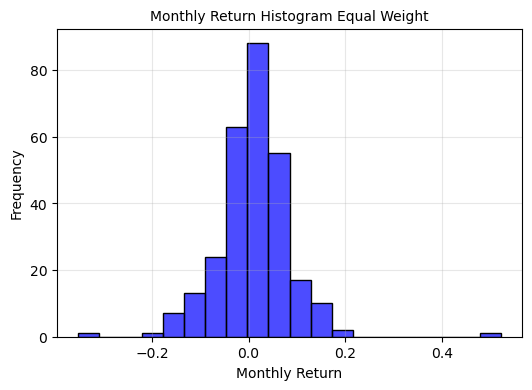

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.figure(figsize=(6, 4))
sns.histplot(port_equal_weight['RET'], bins=20, kde=False, color='blue', edgecolor='black', alpha=0.7)
plt.title('Monthly Return Histogram Equal Weight', fontsize=10)
plt.xlabel('Monthly Return', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

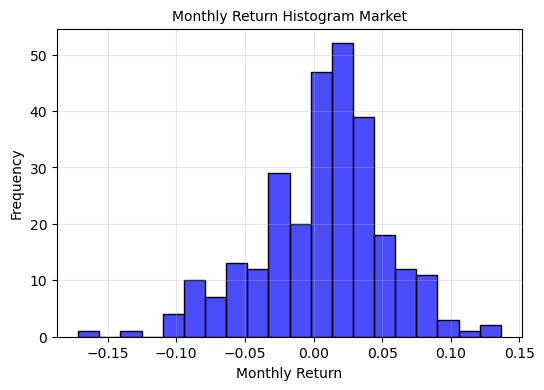

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.figure(figsize=(6, 4))
sns.histplot(port_equal_weight['Market RET'], bins=20, kde=False, color='blue', edgecolor='black', alpha=0.7)
plt.title('Monthly Return Histogram Market', fontsize=10)
plt.xlabel('Monthly Return', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

## Portfolio with Risk Parity

In [39]:
port_risk_parity = pd.DataFrame(stocks_filtered_copy['RET']).reset_index()
port_risk_parity = port_risk_parity.pivot_table(index='DATE', columns='PERMNO', values='RET', aggfunc = 'mean').fillna(0)
port_risk_parity.head()

PERMNO,10092.0,10195.0,10239.0,10257.0,10550.0,10645.0,10661.0,10693.0,10843.0,10874.0,10892.0,11012.0,11137.0,11157.0,11174.0,11208.0,11285.0,11306.0,11348.0,11379.0,11396.0,11406.0,11478.0,11510.0,11522.0,11565.0,11622.0,11625.0,11638.0,11644.0,11654.0,11691.0,11707.0,11748.0,11750.0,11775.0,11790.0,11873.0,11881.0,11884.0,11887.0,11993.0,12010.0,12014.0,12030.0,12036.0,12074.0,12149.0,12310.0,12348.0,12389.0,12477.0,12498.0,12501.0,12586.0,12591.0,12615.0,12629.0,12758.0,12880.0,12906.0,12967.0,13019.0,13116.0,13124.0,13201.0,13278.0,13303.0,13328.0,13507.0,13528.0,13532.0,13603.0,13688.0,13705.0,13708.0,13754.0,13757.0,13904.0,13906.0,13908.0,13921.0,13938.0,13957.0,13970.0,13998.0,14029.0,14040.0,14043.0,14137.0,14179.0,14229.0,14322.0,14337.0,14392.0,14414.0,14558.0,14599.0,14601.0,14603.0,14625.0,14682.0,14684.0,14694.0,14720.0,14776.0,14882.0,14960.0,15008.0,15029.0,15069.0,15088.0,15092.0,15168.0,15203.0,15302.0,15383.0,15398.0,15429.0,15540.0,15623.0,15643.0,15720.0,15721.0,15785.0,15850.0,15860.0,15998.0,16030.0,16049.0,16083.0,16086.0,16119.0,16183.0,16310.0,16378.0,16401.0,16417.0,16432.0,16436.0,16442.0,16471.0,16505.0,16529.0,16569.0,16570.0,16592.0,16653.0,16668.0,16689.0,16753.0,16904.0,16965.0,16991.0,17073.0,17117.0,17121.0,17126.0,17137.0,17140.0,17151.0,17273.0,17332.0,17444.0,17559.0,17672.0,17695.0,17778.0,17787.0,17929.0,17956.0,17970.0,17981.0,18050.0,18106.0,18224.0,18420.0,18421.0,19011.0,19085.0,19271.0,19596.0,19631.0,19722.0,19996.0,20081.0,20161.0,20415.0,20435.0,20583.0,20598.0,20765.0,21020.0,21055.0,21219.0,21598.0,21792.0,21960.0,22293.0,23085.0,24272.0,25073.0,25487.0,25785.0,26607.0,27422.0,27887.0,28118.0,28484.0,28629.0,29938.0,30680.0,31238.0,32054.0,32299.0,32548.0,32678.0,32803.0,32934.0,33137.0,33209.0,33603.0,33849.0,34367.0,34817.0,34833.0,34936.0,37154.0,37234.0,37399.0,37402.0,37699.0,38420.0,39490.0,39731.0,39766.0,41419.0,42067.0,42358.0,42922.0,43028.0,43123.0,43167.0,43617.0,44353.0,44792.0,45129.0,45225.0,45437.0,45495.0,46392.0,46834.0,46843.0,46923.0,46950.0,47133.0,47423.0,47677.0,47706.0,47941.0,48072.0,48144.0,49015.0,49373.0,49429.0,50243.0,50606.0,51457.0,51829.0,51925.0,52250.0,52337.0,52708.0,52936.0,53225.0,53613.0,53831.0,54084.0,54148.0,54244.0,54245.0,55001.0,55546.0,56223.0,56822.0,57154.0,57446.0,57808.0,57904.0,57913.0,58501.0,58886.0,59089.0,59256.0,59396.0,59467.0,59627.0,60353.0,60468.0,60687.0,60695.0,60986.0,61209.0,61508.0,61700.0,62341.0,62383.0,62420.0,62519.0,62763.0,62906.0,63132.0,63546.0,63562.0,63765.0,63773.0,63781.0,63977.0,64282.0,64486.0,64557.0,64565.0,64630.0,64899.0,65285.0,65293.0,66050.0,66078.0,66245.0,66325.0,66384.0,66617.0,66739.0,66800.0,67002.0,67029.0,67046.0,67942.0,68304.0,68830.0,69796.0,70092.0,70228.0,70332.0,71124.0,71909.0,72119.0,72232.0,72696.0,74836.0,74908.0,75104.0,75162.0,75175.0,75233.0,75294.0,75308.0,75342.0,75435.0,75488.0,75503.0,75556.0,75578.0,75729.0,75734.0,75773.0,75789.0,75906.0,75930.0,75945.0,76139.0,76148.0,76195.0,76217.0,76226.0,76360.0,76361.0,76415.0,76478.0,76529.0,76598.0,76622.0,76644.0,76701.0,76708.0,76779.0,76791.0,76845.0,76858.0,76869.0,76879.0,76888.0,76908.0,76951.0,77004.0,77045.0,77074.0,77088.0,77090.0,77114.0,77117.0,77157.0,77205.0,77235.0,77261.0,77274.0,77289.0,77292.0,77334.0,77340.0,77366.0,77438.0,77440.0,77454.0,77461.0,77507.0,77576.0,77608.0,77630.0,77637.0,77661.0,77763.0,77785.0,77889.0,77892.0,77900.0,77915.0,77973.0,77982.0,78001.0,78018.0,78038.0,78068.0,78091.0,78157.0,78170.0,78209.0,78211.0,78213.0,78451.0,78841.0,78877.0,78922.0,79037.0,79066.0,79101.0,79123.0,79147.0,79156.0,79159.0,79204.0,79209.0,79210.0,79244.0,79247.0,79248.0,79323.0,79366.0,79392.0,79407.0,79417.0,79444.0,79490.0,79499.0,79571.0,79731.0,79734.0,79758.0,79785.0,79857.0,79866.0,79867.0,79903.0,79909.0,79915.0,79927.0,80046.0,80073.0,80114.0,80165.0,80169.0,80297.0,80336.0,80478.0,80485.0,80549.0,80557.0,80563.0,80587.0,80633.0,80634.0,80658.0,80797.0,80990.0,81055.0,81084.0,81116.0,81119.0,81128.0,8

In [40]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Step 1: Define risk parity weight calculation
def calculate_risk_parity_weights(cov_matrix):
    num_assets = len(cov_matrix)
    init_guess = np.array([1.0 / num_assets] * num_assets)  # Initial weights
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Weights must sum to 1
    bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling

    # Objective: Minimize the variance of risk contributions
    def risk_parity_objective(weights):
        portfolio_var = weights.T @ cov_matrix @ weights
        marginal_contributions = cov_matrix @ weights
        risk_contributions = weights * marginal_contributions / portfolio_var
        return np.sum((risk_contributions - risk_contributions.mean())**2)

    result = minimize(risk_parity_objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Step 2: Backtest with the zero-return constraint
# portfolio_values_risk_parity = [1]  # Starting portfolio value
weights_history = []

for i in range(1, len(port_risk_parity)):
    # Select stocks dynamically for the month (exclude stocks with zero returns)
    current_month_returns = port_risk_parity.iloc[i]
    selected_stocks = current_month_returns[current_month_returns != 0].index.tolist()  # Filter non-zero returns

    if len(selected_stocks) == 0:
        # Skip this month if no stocks are selected
        portfolio_values_risk_parity.append(portfolio_values_risk_parity[-1])
        continue

    # Calculate covariance matrix for selected stocks
    selected_data = port_risk_parity[selected_stocks].iloc[:i]
    cov_matrix = selected_data.cov()  # Monthly covariance matrix

    # Calculate risk parity weights
    optimal_weights = calculate_risk_parity_weights(cov_matrix)
    

    # Calculate portfolio return for the month
    monthly_portfolio_return = np.dot(optimal_weights, current_month_returns[selected_stocks])
    # new_portfolio_value = portfolio_values_risk_parity[-1] * (1 + monthly_portfolio_return)
    # portfolio_values_risk_parity.append(new_portfolio_value)
    
    weights_history.append((port_risk_parity.index[i], selected_stocks, optimal_weights, monthly_portfolio_return))


/Users/murtadha.ramadhan/anaconda3/envs/py3k/lib/python3.11/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/murtadha.ramadhan/anaconda3/envs/py3k/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/murtadha.ramadhan/anaconda3/envs/py3k/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [41]:
port_risk_parity_weights = pd.DataFrame(weights_history, columns=['Date', 'Picked Stocks', 'Weights', 'RET'])
port_risk_parity_weights.set_index('Date', inplace = True)
port_risk_parity_weights.head()

,Picked Stocks,Weights,RET
Date,,,
2000-02-29,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.020833333333333332, 0.020833333333333332, 0...",0.122432
2000-03-31,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[2.3791875379831114e-17, 2.209675253855728e-18...",0.080187
2000-04-30,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.0, 0.01899795382615392, 0.0945507110841954,...",-0.072047
2000-05-31,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.0, 0.014017791199913457, 3.0956671941980525...",-0.050403
2000-06-30,"[11174.0, 11625.0, 12010.0, 21055.0, 21792.0, ...","[0.017295995497145025, 1.0488275019240212e-05,...",0.030140


In [42]:
initial_value = 1

port_risk_parity_weights['Port Value'] = initial_value * (1 + port_risk_parity_weights['RET']).cumprod().to_list()
port_risk_parity_weights.head()

,Picked Stocks,Weights,RET,Port Value
Date,,,,
2000-02-29,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.020833333333333332, 0.020833333333333332, 0...",0.122432,1.122432
2000-03-31,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[2.3791875379831114e-17, 2.209675253855728e-18...",0.080187,1.212437
2000-04-30,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.0, 0.01899795382615392, 0.0945507110841954,...",-0.072047,1.125084
2000-05-31,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.0, 0.014017791199913457, 3.0956671941980525...",-0.050403,1.068376
2000-06-30,"[11174.0, 11625.0, 12010.0, 21055.0, 21792.0, ...","[0.017295995497145025, 1.0488275019240212e-05,...",0.030140,1.100577


In [43]:
port_risk_parity_weights['Port Running Max'] = port_risk_parity_weights['Port Value'].cummax()

# Calculate Drawdown
port_risk_parity_weights['Port Drawdown'] = (port_risk_parity_weights['Port Value'] - port_risk_parity_weights['Port Running Max']) / port_risk_parity_weights['Port Running Max']

In [44]:
port_risk_parity_weights = port_risk_parity_weights.join(fama_french_data, how='inner')
port_risk_parity_weights['Excess RET'] = port_risk_parity_weights['RET'] - port_risk_parity_weights['RF']
port_risk_parity_weights.head()

,Picked Stocks,Weights,RET,Port Value,Port Running Max,Port Drawdown,Mkt-RF,SMB,HML,RF,Excess RET
Date,,,,,,,,,,,
2000-02-29,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.020833333333333332, 0.020833333333333332, 0...",0.122432,1.122432,1.122432,0.000000,0.0245,0.2136,-0.0959,0.0043,0.118132
2000-03-31,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[2.3791875379831114e-17, 2.209675253855728e-18...",0.080187,1.212437,1.212437,0.000000,0.0520,-0.1720,0.0813,0.0047,0.075487
2000-04-30,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.0, 0.01899795382615392, 0.0945507110841954,...",-0.072047,1.125084,1.212437,-0.072047,-0.0640,-0.0668,0.0726,0.0046,-0.076647
2000-05-31,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.0, 0.014017791199913457, 3.0956671941980525...",-0.050403,1.068376,1.212437,-0.118819,-0.0442,-0.0605,0.0475,0.0050,-0.055403
2000-06-30,"[11174.0, 11625.0, 12010.0, 21055.0, 21792.0, ...","[0.017295995497145025, 1.0488275019240212e-05,...",0.030140,1.100577,1.212437,-0.092261,0.0464,0.1284,-0.0842,0.0040,0.026140


In [45]:
port_risk_parity_weights_summary = port_risk_parity_weights.describe()
port_risk_parity_weights_summary

,RET,Port Value,Port Running Max,Port Drawdown,Mkt-RF,SMB,HML,RF,Excess RET
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,0.010672,4.098784,4.670164,-0.121933,0.005601,0.001664,0.001788,0.001281,0.009391
std,0.069545,2.091398,2.157673,0.131731,0.046192,0.032012,0.035284,0.001495,0.069575
min,-0.321386,1.068376,1.122432,-0.569886,-0.172300,-0.172000,-0.138800,0.000000,-0.322686
25%,-0.023063,2.909883,3.694899,-0.194612,-0.019700,-0.018100,-0.016700,0.000100,-0.023991
50%,0.013772,3.615636,4.150773,-0.083405,0.011700,0.001000,-0.000500,0.000800,0.012413
75%,0.048602,4.820326,5.095954,-0.007601,0.032400,0.018700,0.017800,0.001900,0.047436
max,0.352587,10.037390,10.037390,0.000000,0.136500,0.213600,0.128000,0.005600,0.352587


In [46]:
annual_return_port_risk_parity = port_risk_parity_weights_summary.loc['mean', 'RET']*12
annual_return_std_port_risk_parity = port_risk_parity_weights_summary.loc['std', 'RET']*np.sqrt(12)
annual_excess_return_port_risk_parity = port_risk_parity_weights_summary.loc['mean', 'Excess RET']*12
annual_excess_return_std_port_risk_parity = port_risk_parity_weights_summary.loc['std', 'Excess RET']*np.sqrt(12)
sharpe_ratio_port_risk_parity = (annual_excess_return_port_risk_parity) / annual_excess_return_std_port_risk_parity
max_drawdown_port_risk_parity = port_risk_parity_weights_summary.loc['min', 'Port Drawdown']

print(f'Portfolio Performance with Risk Parity')
print(f'Annualized Return: {annual_return_port_risk_parity*100:.2f}%')
print(f'Volatility: {annual_return_std_port_risk_parity*100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio_port_risk_parity:.2f}')
print(f'Max Drawdown: {max_drawdown_port_risk_parity*100:.2f}%')


Portfolio Performance with Risk Parity
Annualized Return: 12.81%
Volatility: 24.09%
Sharpe Ratio: 0.47
Max Drawdown: -56.99%


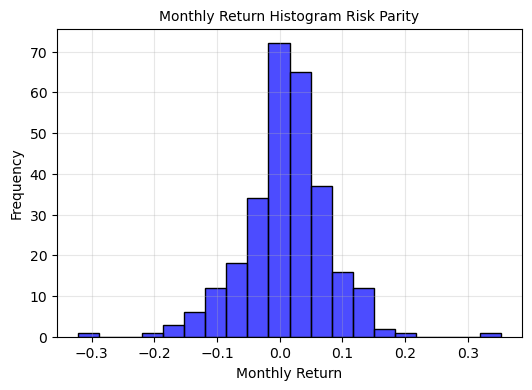

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.figure(figsize=(6, 4))
sns.histplot(port_risk_parity_weights['RET'], bins=20, kde=False, color='blue', edgecolor='black', alpha=0.7)
plt.title('Monthly Return Histogram Risk Parity', fontsize=10)
plt.xlabel('Monthly Return', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

## Portfolio with Mean-Variance Optimization (Sharpe Ratio Maximization)

In [48]:
port_mvo = pd.DataFrame(stocks_filtered_copy['RET']).reset_index()
port_mvo = port_mvo.pivot_table(index='DATE', columns='PERMNO', values='RET', aggfunc = 'mean').fillna(0)
port_mvo.head()

PERMNO,10092.0,10195.0,10239.0,10257.0,10550.0,10645.0,10661.0,10693.0,10843.0,10874.0,10892.0,11012.0,11137.0,11157.0,11174.0,11208.0,11285.0,11306.0,11348.0,11379.0,11396.0,11406.0,11478.0,11510.0,11522.0,11565.0,11622.0,11625.0,11638.0,11644.0,11654.0,11691.0,11707.0,11748.0,11750.0,11775.0,11790.0,11873.0,11881.0,11884.0,11887.0,11993.0,12010.0,12014.0,12030.0,12036.0,12074.0,12149.0,12310.0,12348.0,12389.0,12477.0,12498.0,12501.0,12586.0,12591.0,12615.0,12629.0,12758.0,12880.0,12906.0,12967.0,13019.0,13116.0,13124.0,13201.0,13278.0,13303.0,13328.0,13507.0,13528.0,13532.0,13603.0,13688.0,13705.0,13708.0,13754.0,13757.0,13904.0,13906.0,13908.0,13921.0,13938.0,13957.0,13970.0,13998.0,14029.0,14040.0,14043.0,14137.0,14179.0,14229.0,14322.0,14337.0,14392.0,14414.0,14558.0,14599.0,14601.0,14603.0,14625.0,14682.0,14684.0,14694.0,14720.0,14776.0,14882.0,14960.0,15008.0,15029.0,15069.0,15088.0,15092.0,15168.0,15203.0,15302.0,15383.0,15398.0,15429.0,15540.0,15623.0,15643.0,15720.0,15721.0,15785.0,15850.0,15860.0,15998.0,16030.0,16049.0,16083.0,16086.0,16119.0,16183.0,16310.0,16378.0,16401.0,16417.0,16432.0,16436.0,16442.0,16471.0,16505.0,16529.0,16569.0,16570.0,16592.0,16653.0,16668.0,16689.0,16753.0,16904.0,16965.0,16991.0,17073.0,17117.0,17121.0,17126.0,17137.0,17140.0,17151.0,17273.0,17332.0,17444.0,17559.0,17672.0,17695.0,17778.0,17787.0,17929.0,17956.0,17970.0,17981.0,18050.0,18106.0,18224.0,18420.0,18421.0,19011.0,19085.0,19271.0,19596.0,19631.0,19722.0,19996.0,20081.0,20161.0,20415.0,20435.0,20583.0,20598.0,20765.0,21020.0,21055.0,21219.0,21598.0,21792.0,21960.0,22293.0,23085.0,24272.0,25073.0,25487.0,25785.0,26607.0,27422.0,27887.0,28118.0,28484.0,28629.0,29938.0,30680.0,31238.0,32054.0,32299.0,32548.0,32678.0,32803.0,32934.0,33137.0,33209.0,33603.0,33849.0,34367.0,34817.0,34833.0,34936.0,37154.0,37234.0,37399.0,37402.0,37699.0,38420.0,39490.0,39731.0,39766.0,41419.0,42067.0,42358.0,42922.0,43028.0,43123.0,43167.0,43617.0,44353.0,44792.0,45129.0,45225.0,45437.0,45495.0,46392.0,46834.0,46843.0,46923.0,46950.0,47133.0,47423.0,47677.0,47706.0,47941.0,48072.0,48144.0,49015.0,49373.0,49429.0,50243.0,50606.0,51457.0,51829.0,51925.0,52250.0,52337.0,52708.0,52936.0,53225.0,53613.0,53831.0,54084.0,54148.0,54244.0,54245.0,55001.0,55546.0,56223.0,56822.0,57154.0,57446.0,57808.0,57904.0,57913.0,58501.0,58886.0,59089.0,59256.0,59396.0,59467.0,59627.0,60353.0,60468.0,60687.0,60695.0,60986.0,61209.0,61508.0,61700.0,62341.0,62383.0,62420.0,62519.0,62763.0,62906.0,63132.0,63546.0,63562.0,63765.0,63773.0,63781.0,63977.0,64282.0,64486.0,64557.0,64565.0,64630.0,64899.0,65285.0,65293.0,66050.0,66078.0,66245.0,66325.0,66384.0,66617.0,66739.0,66800.0,67002.0,67029.0,67046.0,67942.0,68304.0,68830.0,69796.0,70092.0,70228.0,70332.0,71124.0,71909.0,72119.0,72232.0,72696.0,74836.0,74908.0,75104.0,75162.0,75175.0,75233.0,75294.0,75308.0,75342.0,75435.0,75488.0,75503.0,75556.0,75578.0,75729.0,75734.0,75773.0,75789.0,75906.0,75930.0,75945.0,76139.0,76148.0,76195.0,76217.0,76226.0,76360.0,76361.0,76415.0,76478.0,76529.0,76598.0,76622.0,76644.0,76701.0,76708.0,76779.0,76791.0,76845.0,76858.0,76869.0,76879.0,76888.0,76908.0,76951.0,77004.0,77045.0,77074.0,77088.0,77090.0,77114.0,77117.0,77157.0,77205.0,77235.0,77261.0,77274.0,77289.0,77292.0,77334.0,77340.0,77366.0,77438.0,77440.0,77454.0,77461.0,77507.0,77576.0,77608.0,77630.0,77637.0,77661.0,77763.0,77785.0,77889.0,77892.0,77900.0,77915.0,77973.0,77982.0,78001.0,78018.0,78038.0,78068.0,78091.0,78157.0,78170.0,78209.0,78211.0,78213.0,78451.0,78841.0,78877.0,78922.0,79037.0,79066.0,79101.0,79123.0,79147.0,79156.0,79159.0,79204.0,79209.0,79210.0,79244.0,79247.0,79248.0,79323.0,79366.0,79392.0,79407.0,79417.0,79444.0,79490.0,79499.0,79571.0,79731.0,79734.0,79758.0,79785.0,79857.0,79866.0,79867.0,79903.0,79909.0,79915.0,79927.0,80046.0,80073.0,80114.0,80165.0,80169.0,80297.0,80336.0,80478.0,80485.0,80549.0,80557.0,80563.0,80587.0,80633.0,80634.0,80658.0,80797.0,80990.0,81055.0,81084.0,81116.0,81119.0,81128.0,8

In [49]:
port_mvo = port_mvo.join(fama_french_data[['RF', 'SMB', 'HML', 'Mkt-RF']], how='inner')
port_mvo.head()

,10092.0,10195.0,10239.0,10257.0,10550.0,10645.0,10661.0,10693.0,10843.0,10874.0,10892.0,11012.0,11137.0,11157.0,11174.0,11208.0,11285.0,11306.0,11348.0,11379.0,11396.0,11406.0,11478.0,11510.0,11522.0,11565.0,11622.0,11625.0,11638.0,11644.0,11654.0,11691.0,11707.0,11748.0,11750.0,11775.0,11790.0,11873.0,11881.0,11884.0,11887.0,11993.0,12010.0,12014.0,12030.0,12036.0,12074.0,12149.0,12310.0,12348.0,12389.0,12477.0,12498.0,12501.0,12586.0,12591.0,12615.0,12629.0,12758.0,12880.0,12906.0,12967.0,13019.0,13116.0,13124.0,13201.0,13278.0,13303.0,13328.0,13507.0,13528.0,13532.0,13603.0,13688.0,13705.0,13708.0,13754.0,13757.0,13904.0,13906.0,13908.0,13921.0,13938.0,13957.0,13970.0,13998.0,14029.0,14040.0,14043.0,14137.0,14179.0,14229.0,14322.0,14337.0,14392.0,14414.0,14558.0,14599.0,14601.0,14603.0,14625.0,14682.0,14684.0,14694.0,14720.0,14776.0,14882.0,14960.0,15008.0,15029.0,15069.0,15088.0,15092.0,15168.0,15203.0,15302.0,15383.0,15398.0,15429.0,15540.0,15623.0,15643.0,15720.0,15721.0,15785.0,15850.0,15860.0,15998.0,16030.0,16049.0,16083.0,16086.0,16119.0,16183.0,16310.0,16378.0,16401.0,16417.0,16432.0,16436.0,16442.0,16471.0,16505.0,16529.0,16569.0,16570.0,16592.0,16653.0,16668.0,16689.0,16753.0,16904.0,16965.0,16991.0,17073.0,17117.0,17121.0,17126.0,17137.0,17140.0,17151.0,17273.0,17332.0,17444.0,17559.0,17672.0,17695.0,17778.0,17787.0,17929.0,17956.0,17970.0,17981.0,18050.0,18106.0,18224.0,18420.0,18421.0,19011.0,19085.0,19271.0,19596.0,19631.0,19722.0,19996.0,20081.0,20161.0,20415.0,20435.0,20583.0,20598.0,20765.0,21020.0,21055.0,21219.0,21598.0,21792.0,21960.0,22293.0,23085.0,24272.0,25073.0,25487.0,25785.0,26607.0,27422.0,27887.0,28118.0,28484.0,28629.0,29938.0,30680.0,31238.0,32054.0,32299.0,32548.0,32678.0,32803.0,32934.0,33137.0,33209.0,33603.0,33849.0,34367.0,34817.0,34833.0,34936.0,37154.0,37234.0,37399.0,37402.0,37699.0,38420.0,39490.0,39731.0,39766.0,41419.0,42067.0,42358.0,42922.0,43028.0,43123.0,43167.0,43617.0,44353.0,44792.0,45129.0,45225.0,45437.0,45495.0,46392.0,46834.0,46843.0,46923.0,46950.0,47133.0,47423.0,47677.0,47706.0,47941.0,48072.0,48144.0,49015.0,49373.0,49429.0,50243.0,50606.0,51457.0,51829.0,51925.0,52250.0,52337.0,52708.0,52936.0,53225.0,53613.0,53831.0,54084.0,54148.0,54244.0,54245.0,55001.0,55546.0,56223.0,56822.0,57154.0,57446.0,57808.0,57904.0,57913.0,58501.0,58886.0,59089.0,59256.0,59396.0,59467.0,59627.0,60353.0,60468.0,60687.0,60695.0,60986.0,61209.0,61508.0,61700.0,62341.0,62383.0,62420.0,62519.0,62763.0,62906.0,63132.0,63546.0,63562.0,63765.0,63773.0,63781.0,63977.0,64282.0,64486.0,64557.0,64565.0,64630.0,64899.0,65285.0,65293.0,66050.0,66078.0,66245.0,66325.0,66384.0,66617.0,66739.0,66800.0,67002.0,67029.0,67046.0,67942.0,68304.0,68830.0,69796.0,70092.0,70228.0,70332.0,71124.0,71909.0,72119.0,72232.0,72696.0,74836.0,74908.0,75104.0,75162.0,75175.0,75233.0,75294.0,75308.0,75342.0,75435.0,75488.0,75503.0,75556.0,75578.0,75729.0,75734.0,75773.0,75789.0,75906.0,75930.0,75945.0,76139.0,76148.0,76195.0,76217.0,76226.0,76360.0,76361.0,76415.0,76478.0,76529.0,76598.0,76622.0,76644.0,76701.0,76708.0,76779.0,76791.0,76845.0,76858.0,76869.0,76879.0,76888.0,76908.0,76951.0,77004.0,77045.0,77074.0,77088.0,77090.0,77114.0,77117.0,77157.0,77205.0,77235.0,77261.0,77274.0,77289.0,77292.0,77334.0,77340.0,77366.0,77438.0,77440.0,77454.0,77461.0,77507.0,77576.0,77608.0,77630.0,77637.0,77661.0,77763.0,77785.0,77889.0,77892.0,77900.0,77915.0,77973.0,77982.0,78001.0,78018.0,78038.0,78068.0,78091.0,78157.0,78170.0,78209.0,78211.0,78213.0,78451.0,78841.0,78877.0,78922.0,79037.0,79066.0,79101.0,79123.0,79147.0,79156.0,79159.0,79204.0,79209.0,79210.0,79244.0,79247.0,79248.0,79323.0,79366.0,79392.0,79407.0,79417.0,79444.0,79490.0,79499.0,79571.0,79731.0,79734.0,79758.0,79785.0,79857.0,79866.0,79867.0,79903.0,79909.0,79915.0,79927.0,80046.0,80073.0,80114.0,80165.0,80169.0,80297.0,80336.0,80478.0,80485.0,80549.0,80557.0,80563.0,80587.0,80633.0,80634.0,80658.0,80797.0,80990.0,81055.0,81084.0,81116.0,81119.0,81128.0,81165.0

In [50]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Step 1: Define Sharpe Ratio maximization function with a dynamic risk-free rate
def calculate_sharpe_ratio_weights(expected_returns, cov_matrix, risk_free_rate):
    num_assets = len(expected_returns)
    init_guess = np.array([1.0 / num_assets] * num_assets)  # Initial weights
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Weights must sum to 1
    bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling

    # Objective: Maximize Sharpe Ratio (or minimize negative Sharpe Ratio)
    def sharpe_ratio_objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_risk = np.sqrt(weights.T @ cov_matrix @ weights)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
        return -sharpe_ratio  # Minimize negative Sharpe Ratio

    result = minimize(sharpe_ratio_objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Step 2: Backtest with the zero-return constraint and dynamic risk-free rate
# portfolio_values_mvo = [1]  # Starting portfolio value
weights_history_mvo = []

for i in range(1, len(port_mvo)):
    # Select stocks dynamically for the month (exclude stocks with zero returns)
    current_month_returns = port_mvo.iloc[i]
    
    selected_stocks = current_month_returns.drop(['RF', 'SMB', 'HML', 'Mkt-RF'])
    selected_stocks = selected_stocks[selected_stocks != 0].index.tolist()  # Filter non-zero returns

    
    if len(selected_stocks) == 0:
        # Skip this month if no stocks are selected
        portfolio_values_mvo.append(portfolio_values_mvo[-1])
        weights_history_mvo.append((port_mvo.index[i], selected_stocks, [], 0))
        continue

    # Extract risk-free rate for the current month
    current_risk_free_rate = port_mvo.loc[port_mvo.index[i], 'RF']
    smb = port_mvo.loc[port_mvo.index[i], 'SMB']
    hml = port_mvo.loc[port_mvo.index[i], 'HML']
    mktrf = port_mvo.loc[port_mvo.index[i], 'Mkt-RF']

    # Calculate expected returns and covariance matrix for selected stocks
    selected_data = port_mvo[selected_stocks].iloc[:i]
    expected_returns = selected_data.mean()  # Average return for each stock
    cov_matrix = selected_data.cov()  # Covariance matrix

    # Calculate Sharpe Ratio optimized weights
    optimal_weights = calculate_sharpe_ratio_weights(expected_returns, cov_matrix, current_risk_free_rate)

    # Calculate portfolio return for the month
    monthly_portfolio_return = np.dot(optimal_weights, current_month_returns[selected_stocks])
    # new_portfolio_value = portfolio_values_mvo[-1] * (1 + monthly_portfolio_return)
    # portfolio_values_mvo.append(new_portfolio_value)

    # Append weights, selected stocks, monthly return, and risk-free rate to weights_history
    weights_history_mvo.append((port_mvo.index[i], selected_stocks, optimal_weights, monthly_portfolio_return, current_risk_free_rate, smb, hml, mktrf))


/Users/murtadha.ramadhan/anaconda3/envs/py3k/lib/python3.11/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/murtadha.ramadhan/anaconda3/envs/py3k/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/murtadha.ramadhan/anaconda3/envs/py3k/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [51]:
port_mvo_weights = pd.DataFrame(weights_history_mvo, columns=['Date', 'Picked Stocks', 'Weights', 'RET', 'RF', 'SMB', 'HML', 'Mkt-RF'])
port_mvo_weights.set_index('Date', inplace = True)

In [52]:
port_mvo_weights['Excess RET'] = port_mvo_weights['RET'] - port_mvo_weights['RF']
port_mvo_weights.head()

,Picked Stocks,Weights,RET,RF,SMB,HML,Mkt-RF,Excess RET
Date,,,,,,,,
2000-02-29,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.020833333333333332, 0.020833333333333332, 0...",0.122432,0.0043,0.2136,-0.0959,0.0245,0.118132
2000-03-31,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[6.4421007193412e-09, 5.082428321482322e-09, 1...",1.111325,0.0047,-0.1720,0.0813,0.0520,1.106625
2000-04-30,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.00037834667088183885, 0.0003720142746725226...",-0.134316,0.0046,-0.0668,0.0726,-0.0640,-0.138916
2000-05-31,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[1.5231231285884924e-06, 3.1686654601378143e-0...",0.162359,0.0050,-0.0605,0.0475,-0.0442,0.157359
2000-06-30,"[11174.0, 11625.0, 12010.0, 21055.0, 21792.0, ...","[0.0, 1.0506989635701673e-10, 1.05069896357016...",0.176055,0.0040,0.1284,-0.0842,0.0464,0.172055


In [53]:
initial_value = 1

port_mvo_weights['Port Value'] = initial_value * (1 + port_mvo_weights['RET']).cumprod().to_list()
port_mvo_weights.head()

,Picked Stocks,Weights,RET,RF,SMB,HML,Mkt-RF,Excess RET,Port Value
Date,,,,,,,,,
2000-02-29,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.020833333333333332, 0.020833333333333332, 0...",0.122432,0.0043,0.2136,-0.0959,0.0245,0.118132,1.122432
2000-03-31,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[6.4421007193412e-09, 5.082428321482322e-09, 1...",1.111325,0.0047,-0.1720,0.0813,0.0520,1.106625,2.369820
2000-04-30,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.00037834667088183885, 0.0003720142746725226...",-0.134316,0.0046,-0.0668,0.0726,-0.0640,-0.138916,2.051514
2000-05-31,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[1.5231231285884924e-06, 3.1686654601378143e-0...",0.162359,0.0050,-0.0605,0.0475,-0.0442,0.157359,2.384595
2000-06-30,"[11174.0, 11625.0, 12010.0, 21055.0, 21792.0, ...","[0.0, 1.0506989635701673e-10, 1.05069896357016...",0.176055,0.0040,0.1284,-0.0842,0.0464,0.172055,2.804415


In [54]:
port_mvo_weights['Port Running Max'] = port_mvo_weights['Port Value'].cummax()

# Calculate Drawdown
port_mvo_weights['Port Drawdown'] = (port_mvo_weights['Port Value'] - port_mvo_weights['Port Running Max']) / port_mvo_weights['Port Running Max']

In [55]:
port_mvo_weights_summary = port_mvo_weights.describe()
port_mvo_weights_summary

,RET,RF,SMB,HML,Mkt-RF,Excess RET,Port Value,Port Running Max,Port Drawdown
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,0.014545,0.001281,0.001664,0.001788,0.005601,0.013265,9.887858,12.821811,-0.209573
std,0.093588,0.001495,0.032012,0.035284,0.046192,0.093392,5.285918,5.575178,0.198339
min,-0.305626,0.000000,-0.172000,-0.138800,-0.172300,-0.306926,1.122432,1.122432,-0.631683
25%,-0.024975,0.000100,-0.018100,-0.016700,-0.019700,-0.025332,6.713877,9.028175,-0.399755
50%,0.015894,0.000800,0.001000,-0.000500,0.011700,0.015532,8.598690,14.357351,-0.151285
75%,0.048610,0.001900,0.018700,0.017800,0.032400,0.047457,12.375081,14.357351,-0.028453
max,1.111325,0.005600,0.213600,0.128000,0.136500,1.106625,24.561803,24.561803,0.000000


In [56]:
annual_return_port_mvo = port_mvo_weights_summary.loc['mean', 'RET']*12
annual_return_std_port_mvo = port_mvo_weights_summary.loc['std', 'RET']*np.sqrt(12)
annual_excess_return_port_mvo = port_mvo_weights_summary.loc['mean', 'Excess RET']*12
annual_excess_return_std_port_mvo = port_mvo_weights_summary.loc['std', 'Excess RET']*np.sqrt(12)
sharpe_ratio_port_mvo = (annual_excess_return_port_mvo) / annual_excess_return_std_port_mvo
max_drawdown_port_mvo = port_mvo_weights_summary.loc['min', 'Port Drawdown']

print(f'Portfolio Performance with Mean-Variance Optimization with Sharpe Ratio Maximization')
print(f'Annualized Return: {annual_return_port_mvo*100:.2f}%')
print(f'Volatility: {annual_return_std_port_mvo*100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio_port_mvo:.2f}')
print(f'Max Drawdown: {max_drawdown_port_mvo*100:.2f}%')

Portfolio Performance with Mean-Variance Optimization with Sharpe Ratio Maximization
Annualized Return: 17.45%
Volatility: 32.42%
Sharpe Ratio: 0.49
Max Drawdown: -63.17%


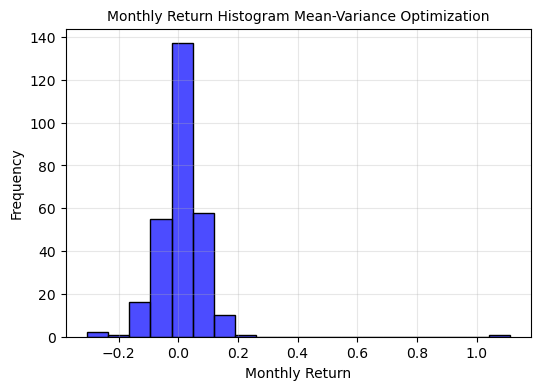

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.figure(figsize=(6, 4))
sns.histplot(port_mvo_weights['RET'], bins=20, kde=False, color='blue', edgecolor='black', alpha=0.7)
plt.title('Monthly Return Histogram Mean-Variance Optimization', fontsize=10)
plt.xlabel('Monthly Return', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

## Portfolio with Minimum Variance

In [58]:
port_min_variance = pd.DataFrame(stocks_filtered_copy['RET']).reset_index()
port_min_variance = port_min_variance.pivot_table(index='DATE', columns='PERMNO', values='RET', aggfunc = 'mean').fillna(0)
port_min_variance.head(10)

PERMNO      10092.0   10195.0  10239.0  10257.0  10550.0  10645.0  10661.0  \
DATE                                                                         
2000-01-31      0.0 -0.015810      0.0      0.0      0.0      0.0      0.0   
2000-02-29      0.0 -0.153614      0.0      0.0      0.0      0.0      0.0   
2000-03-31      0.0 -0.117438      0.0      0.0      0.0      0.0      0.0   
2000-04-30      0.0  0.075269      0.0      0.0      0.0      0.0      0.0   
2000-05-31      0.0 -0.061250      0.0      0.0      0.0      0.0      0.0   
2000-06-30      0.0  0.000000      0.0      0.0      0.0      0.0      0.0   
2000-07-31      0.0  0.000000      0.0      0.0      0.0      0.0      0.0   
2000-08-31      0.0  0.000000      0.0      0.0      0.0      0.0      0.0   
2000-09-30      0.0  0.000000      0.0      0.0      0.0      0.0      0.0   
2000-10-31      0.0  0.000000      0.0      0.0      0.0      0.0      0.0   

PERMNO      10693.0  10843.0  10874.0  10892.0  11012.0  11137.0  11157.0  \
DATE                                                                        
2000-01-31      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2000-02-29      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2000-03-31      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2000-04-30      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2000-05-31      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2000-06-30      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2000-07-31      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2000-08-31      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2000-09-30      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2000-10-31      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

PERMNO       11174.0  11208.0  11285.0  11306.0  11348.0  11379.0  11396.0  \
DATE                                                                         
2000-01-31 -0.037975      0.0      0.0      0.0      0.0      0.0      0.0   
2000-02-29 -0.039474      0.0      0.0      0.0      0.0      0.0      0.0   
2000-03-31  0.273973      0.0      0.0      0.0      0.0      0.0      0.0   
2000-04-30 -0.096774      0.0      0.0      0.0      0.0      0.0      0.0   
2000-05-31 -0.023810      0.0      0.0      0.0      0.0      0.0      0.0   
2000-06-30 -0.006098      0.0      0.0      0.0      0.0      0.0      0.0   
2000-07-31  0.006135      0.0      0.0      0.0      0.0      0.0      0.0   
2000-08-31 -0.006098      0.0      0.0      0.0      0.0      0.0      0.0   
2000-09-30 -0.055215      0.0      0.0      0.0      0.0      0.0      0.0   
2000-10-31  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   

PERMNO      11406.0  11478.0  11510.0   11522.0  11565.0   11622.0   11625.0  \
DATE                                                                           
2000-01-31      0.0      0.0      0.0  0.112299      0.0 -0.046512  0.000000   
2000-02-29      0.0      0.0      0.0 -0.423077      0.0  0.000000  0.000000   
2000-03-31      0.0      0.0      0.0  0.216667      0.0 -0.061463  0.000000   
2000-04-30      0.0      0.0      0.0 -0.027397      0.0  0.052632  0.000000   
2000-05-31      0.0      0.0      0.0  1.091549      0.0  0.000000  0.000000   
2000-06-30      0.0      0.0      0.0  0.000000      0.0  0.000000  0.173469   
2000-07-31      0.0      0.0      0.0  0.000000      0.0  0.000000  0.026087   
2000-08-31      0.0      0.0      0.0  0.000000      0.0  0.000000 -0.186441   
2000-09-30      0.0      0.0      0.0  0.000000      0.0  0.000000  0.114583   
2000-10-31      0.0      0.0      0.0  0.000000      0.0  0.000000  0.084112   

PERMNO       11638.0  11644.0  11654.0  11691.0  11707.0  11748.0  11750.0  \
DATE                                                                         
2000-01-31  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
2000-0

In [59]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Step 1: Define Minimum Variance Optimization function
def calculate_minimum_variance_weights(cov_matrix):
    num_assets = len(cov_matrix)
    init_guess = np.array([1.0 / num_assets] * num_assets)  # Initial weights
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Weights must sum to 1
    bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling

    # Objective: Minimize portfolio variance
    def variance_objective(weights):
        return weights.T @ cov_matrix @ weights  # Portfolio variance

    result = minimize(variance_objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Step 2: Backtest with the zero-return constraint
# portfolio_values_min_variance = [1]  # Starting portfolio value
weights_history_min_variance = []

for i in range(1, len(port_min_variance)):
    # Select stocks dynamically for the month (exclude stocks with zero returns)
    current_month_returns = port_min_variance.iloc[i]
    selected_stocks = current_month_returns[current_month_returns != 0].index.tolist()  # Filter non-zero returns

    if len(selected_stocks) == 0:
        # Skip this month if no stocks are selected
        portfolio_values_min_variance.append(portfolio_values_min_variance[-1])
        weights_history_min_variance.append((port_min_variance.index[i], selected_stocks, [], 0))
        continue

    # Calculate covariance matrix for the selected stocks
    selected_data = port_min_variance[selected_stocks].iloc[:i]
    cov_matrix = selected_data.cov()  # Covariance matrix

    # Calculate minimum variance weights
    optimal_weights = calculate_minimum_variance_weights(cov_matrix)

    # Calculate portfolio return for the month
    monthly_portfolio_return = np.dot(optimal_weights, current_month_returns[selected_stocks])
    # new_portfolio_value = portfolio_values_min_variance[-1] * (1 + monthly_portfolio_return)
    # portfolio_values_min_variance.append(new_portfolio_value)

    # Append weights, selected stocks, and monthly return to weights_history
    weights_history_min_variance.append((port_min_variance.index[i], selected_stocks, optimal_weights, monthly_portfolio_return))


/Users/murtadha.ramadhan/anaconda3/envs/py3k/lib/python3.11/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/murtadha.ramadhan/anaconda3/envs/py3k/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/murtadha.ramadhan/anaconda3/envs/py3k/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [60]:
port_min_variance_weights = pd.DataFrame(weights_history_min_variance, columns=['Date', 'Picked Stocks', 'Weights', 'RET'])
port_min_variance_weights.set_index('Date', inplace = True)

In [61]:
port_min_variance_weights = port_min_variance_weights.join(fama_french_data, how='inner')
port_min_variance_weights['Excess RET'] = port_min_variance_weights['RET'] - port_min_variance_weights['RF']
port_min_variance_weights.head()

,Picked Stocks,Weights,RET,Mkt-RF,SMB,HML,RF,Excess RET
Date,,,,,,,,
2000-02-29,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.020833333333333332, 0.020833333333333332, 0...",0.122432,0.0245,0.2136,-0.0959,0.0043,0.118132
2000-03-31,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.023627514832457185, 0.020451461153790915, 0...",0.057835,0.0520,-0.1720,0.0813,0.0047,0.053135
2000-04-30,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.02343694029549182, 0.01799735350317931, 0.0...",-0.074548,-0.0640,-0.0668,0.0726,0.0046,-0.079148
2000-05-31,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.042683461768589656, 0.012629912850642971, 0...",0.018764,-0.0442,-0.0605,0.0475,0.0050,0.013764
2000-06-30,"[11174.0, 11625.0, 12010.0, 21055.0, 21792.0, ...","[0.012714175797511242, 0.023778171908305546, 0...",0.028098,0.0464,0.1284,-0.0842,0.0040,0.024098


In [62]:
initial_value = 1

port_min_variance_weights['Port Value'] = initial_value * (1 + port_min_variance_weights['RET']).cumprod().to_list()
port_min_variance_weights.head()

,Picked Stocks,Weights,RET,Mkt-RF,SMB,HML,RF,Excess RET,Port Value
Date,,,,,,,,,
2000-02-29,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.020833333333333332, 0.020833333333333332, 0...",0.122432,0.0245,0.2136,-0.0959,0.0043,0.118132,1.122432
2000-03-31,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.023627514832457185, 0.020451461153790915, 0...",0.057835,0.0520,-0.1720,0.0813,0.0047,0.053135,1.187349
2000-04-30,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.02343694029549182, 0.01799735350317931, 0.0...",-0.074548,-0.0640,-0.0668,0.0726,0.0046,-0.079148,1.098834
2000-05-31,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.042683461768589656, 0.012629912850642971, 0...",0.018764,-0.0442,-0.0605,0.0475,0.0050,0.013764,1.119453
2000-06-30,"[11174.0, 11625.0, 12010.0, 21055.0, 21792.0, ...","[0.012714175797511242, 0.023778171908305546, 0...",0.028098,0.0464,0.1284,-0.0842,0.0040,0.024098,1.150906


In [63]:
port_min_variance_weights['Port Running Max'] = port_min_variance_weights['Port Value'].cummax()

# Calculate Drawdown
port_min_variance_weights['Port Drawdown'] = (port_min_variance_weights['Port Value'] - port_min_variance_weights['Port Running Max']) / port_min_variance_weights['Port Running Max']

In [64]:
port_min_variance_weights_summary = port_min_variance_weights.describe()
port_min_variance_weights_summary

,RET,Mkt-RF,SMB,HML,RF,Excess RET,Port Value,Port Running Max,Port Drawdown
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,0.009849,0.005601,0.001664,0.001788,0.001281,0.008568,3.442064,3.828994,-0.101384
std,0.062494,0.046192,0.032012,0.035284,0.001495,0.062585,1.898605,2.008702,0.107016
min,-0.312298,-0.172300,-0.172000,-0.138800,0.000000,-0.313598,1.098834,1.122432,-0.436509
25%,-0.015483,-0.019700,-0.018100,-0.016700,0.000100,-0.016229,2.193335,2.505965,-0.153001
50%,0.012991,0.011700,0.001000,-0.000500,0.000800,0.011676,2.893470,3.566441,-0.070258
75%,0.046558,0.032400,0.018700,0.017800,0.001900,0.043062,4.375031,4.514424,-0.008468
max,0.300315,0.136500,0.213600,0.128000,0.005600,0.300315,9.060774,9.060774,0.000000


In [65]:
annual_return_port_min_variance = port_min_variance_weights_summary.loc['mean', 'RET']*12
annual_return_std_port_min_variance = port_min_variance_weights_summary.loc['std', 'RET']*np.sqrt(12)
annual_excess_return_port_min_variance = port_min_variance_weights_summary.loc['mean', 'Excess RET']*12
annual_excess_return_std_port_min_variance = port_min_variance_weights_summary.loc['std', 'Excess RET']*np.sqrt(12)
sharpe_ratio_port_min_variance = (annual_excess_return_port_min_variance) / annual_excess_return_std_port_min_variance
max_drawdown_port_min_variance = port_min_variance_weights_summary.loc['min', 'Port Drawdown']

print(f'Portfolio Performance with Minimum Variance Optimization')
print(f'Annualized Return: {annual_return_port_min_variance*100:.2f}%')
print(f'Volatility: {annual_return_std_port_min_variance*100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio_port_min_variance:.2f}')
print(f'Max Drawdown: {max_drawdown_port_min_variance*100:.2f}%')


Portfolio Performance with Minimum Variance Optimization
Annualized Return: 11.82%
Volatility: 21.65%
Sharpe Ratio: 0.47
Max Drawdown: -43.65%


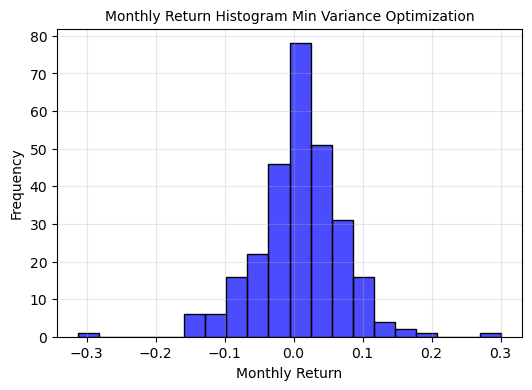

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.figure(figsize=(6, 4))
sns.histplot(port_min_variance_weights['RET'], bins=20, kde=False, color='blue', edgecolor='black', alpha=0.7)
plt.title('Monthly Return Histogram Min Variance Optimization', fontsize=10)
plt.xlabel('Monthly Return', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

## Performance Evaluation

### Risk Parity

In [67]:
port_risk_parity_weights_performance = port_risk_parity_weights.copy()
port_risk_parity_weights_performance = port_risk_parity_weights_performance.rename(columns={'Excess RET': 'ExcessRET', 'Mkt-RF': 'MktRF'})

In [68]:
port_risk_parity_weights_performance.head()

,Picked Stocks,Weights,RET,Port Value,Port Running Max,Port Drawdown,MktRF,SMB,HML,RF,ExcessRET
Date,,,,,,,,,,,
2000-02-29,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.020833333333333332, 0.020833333333333332, 0...",0.122432,1.122432,1.122432,0.000000,0.0245,0.2136,-0.0959,0.0043,0.118132
2000-03-31,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[2.3791875379831114e-17, 2.209675253855728e-18...",0.080187,1.212437,1.212437,0.000000,0.0520,-0.1720,0.0813,0.0047,0.075487
2000-04-30,"[10195.0, 11174.0, 11522.0, 11622.0, 16417.0, ...","[0.0, 0.01899795382615392, 0.0945507110841954,...",-0.072047,1.125084,1.212437,-0.072047,-0.0640,-0.0668,0.0726,0.0046,-0.076647
2000-05-31,"[10195.0, 11174.0, 11522.0, 16417.0, 21055.0, ...","[0.0, 0.014017791199913457, 3.0956671941980525...",-0.050403,1.068376,1.212437,-0.118819,-0.0442,-0.0605,0.0475,0.0050,-0.055403
2000-06-30,"[11174.0, 11625.0, 12010.0, 21055.0, 21792.0, ...","[0.017295995497145025, 1.0488275019240212e-05,...",0.030140,1.100577,1.212437,-0.092261,0.0464,0.1284,-0.0842,0.0040,0.026140


In [69]:
reg_risk_parity = smf.ols('ExcessRET ~ MktRF + SMB + HML', data=port_risk_parity_weights_performance).fit()
print(reg_risk_parity.summary())

                            OLS Regression Results                            
Dep. Variable:              ExcessRET   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     202.6
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           1.52e-69
Time:                        11:48:41   Log-Likelihood:                 513.93
No. Observations:                 281   AIC:                            -1020.
Df Residuals:                     277   BIC:                            -1005.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0016      0.002      0.682      0.4

### Mean-Variance Optimization

In [70]:
port_mvo_weights_performance = port_mvo_weights.copy()
port_mvo_weights_performance = port_mvo_weights_performance.rename(columns={'Excess RET': 'ExcessRET', 'Mkt-RF': 'MktRF'})

In [71]:
reg_mvo = smf.ols('ExcessRET ~ MktRF + SMB + HML', data=port_mvo_weights_performance).fit()
print(reg_mvo.summary())

                            OLS Regression Results                            
Dep. Variable:              ExcessRET   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     32.47
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           5.14e-18
Time:                        11:48:41   Log-Likelihood:                 310.36
No. Observations:                 281   AIC:                            -612.7
Df Residuals:                     277   BIC:                            -598.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0072      0.005      1.478      0.1

### Minimum Variance Optimization

In [72]:
port_min_variance_weights_performance = port_min_variance_weights.copy()
port_min_variance_weights_performance = port_min_variance_weights_performance.rename(columns={'Excess RET': 'ExcessRET', 'Mkt-RF': 'MktRF'})

In [73]:
reg_min_variance = smf.ols('ExcessRET ~ MktRF + SMB + HML', data=port_min_variance_weights_performance).fit()
print(reg_min_variance.summary())

                            OLS Regression Results                            
Dep. Variable:              ExcessRET   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     218.2
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           1.26e-72
Time:                        11:48:41   Log-Likelihood:                 550.89
No. Observations:                 281   AIC:                            -1094.
Df Residuals:                     277   BIC:                            -1079.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0016      0.002      0.753      0.4

# Summary

In [74]:
print(f'Portfolio Performance with Minimum Variance Optimization')
print(f'Annualized Return: {annual_return_port_min_variance*100:.2f}%')
print(f'Volatility: {annual_return_std_port_min_variance*100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio_port_min_variance:.2f}')
print(f'Max Drawdown: {max_drawdown_port_min_variance*100:.2f}%')

Portfolio Performance with Minimum Variance Optimization
Annualized Return: 11.82%
Volatility: 21.65%
Sharpe Ratio: 0.47
Max Drawdown: -43.65%


In [76]:
all_strategies = ['Market', 'Equal Weight', 'Risk Parity', 'Mean-Variance Optimization', 'Minimum Variance Optimization']
all_annualized_return = [annual_return_market, annual_return_port_equal, annual_return_port_risk_parity, annual_return_port_mvo, annual_return_port_min_variance]

all_volatility = [annual_return_std_market, annual_return_std_port_equal, annual_return_std_port_risk_parity, annual_return_std_port_mvo, annual_return_std_port_min_variance]
all_sharpe_ratio = [sharpe_ratio_market, sharpe_ratio_port_equal, sharpe_ratio_port_risk_parity, sharpe_ratio_port_mvo, sharpe_ratio_port_min_variance]
all_max_drawdown = [max_drawdown_market, max_drawdown_port_equal, max_drawdown_port_risk_parity, max_drawdown_port_mvo, max_drawdown_port_min_variance]

In [77]:
# Combine into a single DataFrame
all_summary = {
    'Strategies/Market': all_strategies,
    'Annual Return': all_annualized_return,
    'Volatility': all_volatility,
    'Sharpe Ratio': all_sharpe_ratio,
    'Max Drawdown': all_max_drawdown
}
all_summary_df = pd.DataFrame(all_summary)
all_summary_df.set_index('Strategies/Market', inplace=True)

all_summary_df['Annual Return'] = all_summary_df['Annual Return'].apply(lambda x: f"{x * 100:.2f}%")
all_summary_df['Volatility'] = all_summary_df['Volatility'].apply(lambda x: f"{x * 100:.2f}%")
all_summary_df['Sharpe Ratio'] = all_summary_df['Sharpe Ratio'].apply(lambda x: f"{x :.2f}")
all_summary_df['Max Drawdown'] = all_summary_df['Max Drawdown'].apply(lambda x: f"{x * 100:.2f}%")

all_summary_df

,Annual Return,Volatility,Sharpe Ratio,Max Drawdown
Strategies/Market,,,,
Market,8.05%,15.95%,0.41,-50.39%
Equal Weight,13.01%,26.00%,0.44,-56.69%
Risk Parity,12.81%,24.09%,0.47,-56.99%
Mean-Variance Optimization,17.45%,32.42%,0.49,-63.17%
Minimum Variance Optimization,11.82%,21.65%,0.47,-43.65%


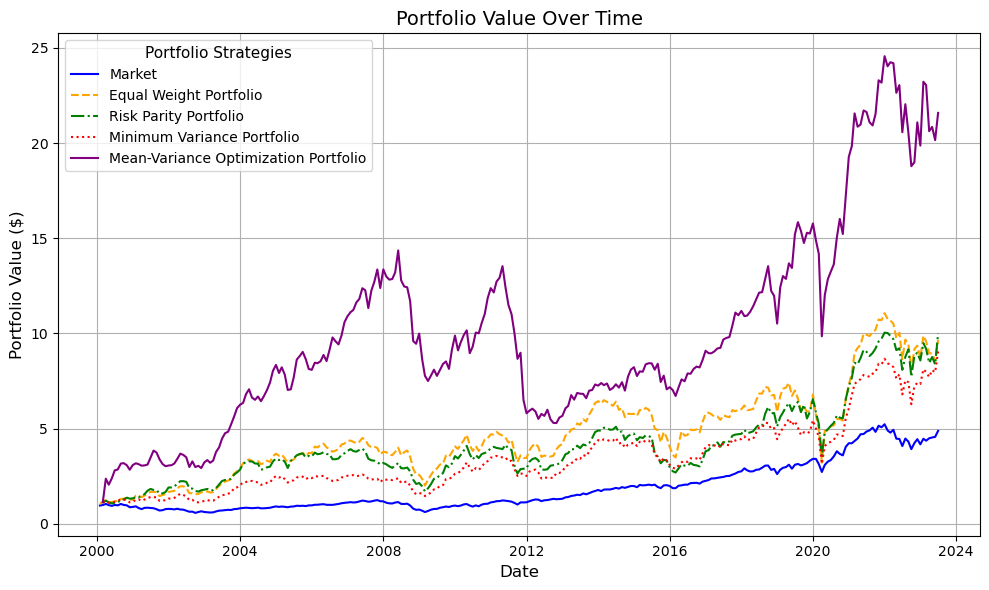

In [78]:
import matplotlib.pyplot as plt

# Plot each portfolio value line with a label for the legend
plt.figure(figsize=(10, 6))

plt.plot(port_equal_weight['Market Value'], label='Market', color='blue', linestyle='-')
plt.plot(port_equal_weight['Port Value'], label='Equal Weight Portfolio', color='orange', linestyle='--')
plt.plot(port_risk_parity_weights['Port Value'], label='Risk Parity Portfolio', color='green', linestyle='-.')
plt.plot(port_min_variance_weights['Port Value'], label='Minimum Variance Portfolio', color='red', linestyle=':')
plt.plot(port_mvo_weights['Port Value'], label='Mean-Variance Optimization Portfolio', color='purple', linestyle='-')

# Add title, axis labels, grid, and legend
plt.title('Portfolio Value Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.grid(True)
plt.legend(title="Portfolio Strategies", fontsize=10, title_fontsize=11)

# Display the plot
plt.tight_layout()
plt.show()